# 🌀 Performance Analysis of Cyclone Dust Collectors at Different Stages of Rotary Drying of Coir Pith

This simulation focuses on modeling a cyclone dust collector used during the rotary drying of coir pith. The primary goal is to **enhance the selective recovery of coarser particles, which contribute to export-grade quality, while reducing the recovery of finer particles that may compromise product standards.**

The cyclone is modeled using Lapple’s General Purpose design, and the Muschelknautz efficiency model is applied to estimate the grade separation efficiency across different particle sizes.

By varying critical parameters such as the **cyclone body diameter** and **inlet gas flow rate**, the simulation evaluates how these design choices influence the **separation performance** and helps identify configurations that maximize desirable particle recovery.

In [ ]:
# import required python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from tabulate import tabulate

### 1. Physical Constants

The simulation begins by defining the key physical properties of the gas–solid system involved in cyclone separation:

- `ρₚ` (rho_p): Density of coir pith particles, set to **939 kg/m³**, based on experimental data.
- `ρg` (rho_g): Density of air, assumed to be **1.2 kg/m³** under standard conditions.
- `μ` (mu): Dynamic viscosity of air, taken as **1.8 × 10⁻⁵ Pa·s**.
- `Q`: Volumetric flow rate of the inlet air stream, assumed to be **0.5 m³/s** for typical cyclone operation.
- `dₑₓ` (d_ex): Target cut-off particle diameter, set to **0.5 mm**, representing the size above which particles should ideally be captured by the cyclone.

In [ ]:
# Physical constants
rho_p = 939
rho_g = 1.2
mu = 1.8e-5
Q = 0.5
d_ex = 0.5 # in mm

### 2. Lapple Cyclone Design Ratios

The cyclone geometry is defined using standard Lapple General Purpose design ratios.

In [ ]:
cyclone_ratios = {
    'Dc': 0.5,        # Cyclone body diameter (m)
    'a': 0.5,         # Inlet height ratio (H/D)
    'b': 0.25,        # Inlet width ratio (W/D)
    'De': 0.5,        # Exit pipe diameter ratio (De/D)
    'S': 0.625,       # Vortex finder length ratio (S/D)
    'h': 2.0,         # Cylinder (body) height ratio (Lb/D)
    'B': 2.0,         # Cone height ratio (Lc/D)
    'Dd': 0.25        # Dust outlet diameter ratio (Dd/D)
}

### 3. Particle Size Bins

To evaluate separation efficiency, particles are grouped into size bins based on their diameter ranges. Each bin is represented by its mid-point diameter (in millimeters), which is used in efficiency calculations.


In [ ]:
# Particle bins used for efficiency calculations
particle_bins = {
    "greater_2mm": 2.5,
    "2-1.4mm": 1.7,
    "1.4-1mm": 1.2,
    "1-0.5mm": 0.75,
    "0.5-0.2mm": 0.35,
    "less_0.2mm": 0.1
}

### 4. Load the Dataset

This section loads two datasets representing the particle size distributions at different stages of the rotary drying process:

- **`data_dryer`**: Contains samples taken during the rotary drying of coir pith.
- **`data_normal`**: Represents a standard or control condition of the coir pith particles.

Each dataset includes mass fraction percentages for six particle size bins:
- greater_2mm  
- 2-1.4mm  
- 1.4-1mm  
- 1-0.5mm  
- 0.5-0.2mm  
- less_0.2mm


In [ ]:
data_dryer = pd.DataFrame({
    "Sample": [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00, 8.00, 9.00, 10.00, 11.00, 12.00, 13.00, 14.00, 15.00, 16.00, 17.00, 18.00, 19.00, 20.00, 21.00, 22.00, 23.00, 24.00, 25.00, 26.00, 27.00, 28.00, 29.00, 30.00, 31.00, 32.00, 33.00, 34.00, 35.00, 36.00, 37.00, 38.00, 39.00, 40.00, 41.00, 42.00, 43.00, 44.00, 45.00, 46.00, 47.00, 48.00, 49.00, 50.00, 51.00, 52.00, 53.00, 54.00],
    "greater_2mm": [16.90, 18.00, 16.40, 19.90, 19.90, 17.66, 15.56, 26.20, 27.10, 4.05, 4.94, 14.30, 15.30, 13.83, 12.84, 17.40, 16.32, 12.57, 13.54, 15.00, 16.30, 18.34, 17.80, 11.64, 9.80, 10.90, 12.50, 13.93, 15.80, 15.90, 15.96, 16.27, 17.30, 12.13, 13.14, 12.32, 18.70, 15.40, 19.30, 15.39, 13.20, 13.50, 12.10, 12.84, 14.40, 13.93, 14.80, 15.90, 14.13, 13.14, 12.32, 17.60, 15.20, 16.80],
    "2-1.4mm": [27.50, 28.00, 30.50, 32.12, 32.40, 28.53, 40.14, 18.11, 19.30, 41.41, 41.40, 21.50, 20.50, 25.00, 24.80, 29.50, 30.43, 12.93, 13.98, 15.72, 14.30, 22.40, 25.40, 15.72, 14.97, 13.20, 13.90, 15.20, 16.60, 16.50, 20.66, 21.11, 20.90, 18.20, 14.94, 14.88, 21.00, 19.30, 20.35, 20.73, 18.70, 20.30, 16.97, 20.80, 29.50, 21.00, 18.60, 15.50, 19.20, 17.94, 15.88, 24.00, 25.30, 23.30],
    "1.4-1mm": [16.10, 14.00, 15.18, 13.76, 15.10, 20.65, 14.32, 23.53, 21.09, 18.06, 16.62, 14.00, 14.02, 16.00, 17.30, 15.18, 17.32, 14.44, 15.54, 17.78, 18.30, 18.43, 18.40, 18.48, 16.11, 18.10, 16.30, 16.10, 18.01, 17.10, 19.67, 19.62, 19.10, 18.89, 17.58, 17.79, 15.90, 18.30, 10.97, 15.52, 17.23, 16.00, 16.30, 16.30, 17.18, 16.10, 16.01, 18.50, 17.89, 17.58, 19.79, 22.70, 25.30, 22.60],
    "1-0.5mm": [29.50, 29.00, 30.70, 25.70, 25.40, 28.12, 24.24, 28.53, 28.30, 28.53, 28.51, 27.70, 27.70, 29.10, 28.60, 29.20, 28.24, 30.20, 28.40, 28.80, 29.30, 28.20, 27.60, 31.69, 29.40, 30.90, 31.20, 29.50, 28.80, 26.90, 30.06, 30.43, 29.00, 30.39, 30.50, 30.20, 28.90, 28.11, 28.90, 30.02, 28.70, 30.01, 28.30, 29.60, 25.20, 26.50, 27.80, 26.90, 27.39, 28.56, 29.20, 27.70, 26.30, 27.20],
    "0.5-0.2mm": [7.00, 7.10, 5.70, 5.20, 5.80, 4.22, 3.71, 2.53, 3.30, 7.72, 7.59, 18.30, 16.70, 12.62, 12.30, 5.50, 3.71, 26.70, 27.40, 17.66, 18.20, 7.40, 8.20, 17.64, 22.60, 20.02, 18.80, 18.70, 15.30, 15.90, 10.14, 10.06, 10.34, 14.96, 19.30, 17.58, 11.47, 13.20, 15.10, 13.74, 17.70, 17.20, 21.20, 16.30, 10.50, 15.70, 17.30, 17.90, 16.96, 18.30, 19.58, 5.50, 4.64, 6.50],
    "less_0.2mm": [2.60, 1.90, 1.25, 0.15, 1.20, 0.13, 0.82, 0.42, 0.34, 0.39, 0.39, 3.47, 5.19, 2.91, 3.03, 2.32, 3.82, 2.87, 1.10, 4.90, 3.20, 4.60, 2.40, 4.20, 6.60, 5.90, 6.60, 5.85, 5.10, 7.40, 3.40, 1.86, 3.12, 4.82, 4.13, 7.01, 2.90, 5.25, 4.80, 3.05, 4.40, 2.90, 4.30, 4.03, 2.32, 5.85, 5.10, 4.80, 3.82, 4.13, 3.01, 1.86, 1.75, 2.65]
})

data_normal = pd.DataFrame({
    "Sample": list(range(1, 41)),
    "greater_2mm": [13.93, 16.07, 14.38, 12.60, 10.54, 11.90, 12.10, 12.48, 14.64, 16.77, 11.43, 11.50, 15.60, 13.30, 14.43, 14.50, 12.50, 14.80, 15.30, 15.77, 8.70, 11.80, 12.10, 11.70, 9.40, 11.80, 12.80, 14.90, 12.90, 11.10, 11.20, 11.90, 7.50, 8.80, 9.30, 12.10, 8.90, 12.70, 11.50, 9.90],
    "2-1.4mm": [19.63, 17.09, 17.30, 17.19, 14.53, 16.80, 15.94, 16.93, 17.42, 20.63, 15.28, 13.95, 18.50, 15.66, 16.40, 17.67, 16.90, 15.60, 16.90, 19.63, 11.70, 11.30, 14.10, 12.60, 10.10, 12.90, 12.10, 11.80, 12.80, 13.20, 14.30, 12.50, 13.50, 12.60, 13.30, 12.70, 11.90, 10.50, 14.30, 13.90],
    "1.4-1mm": [16.72, 14.54, 15.70, 15.83, 13.99, 14.50, 15.93, 17.39, 14.90, 18.39, 16.48, 15.60, 16.40, 14.34, 16.40, 17.33, 16.80, 18.70, 18.30, 17.39, 12.10, 12.10, 11.80, 12.20, 12.70, 15.60, 13.00, 11.90, 13.60, 14.70, 13.80, 12.40, 13.10, 14.40, 13.70, 14.40, 14.70, 12.90, 13.30, 15.10],
    "1-0.5mm": [25.48, 24.87, 24.90, 30.29, 27.23, 24.60, 27.47, 26.36, 26.80, 28.53, 28.27, 27.72, 24.60, 27.80, 26.70, 23.40, 27.70, 28.00, 27.00, 28.53, 20.80, 23.10, 23.90, 23.20, 25.60, 26.60, 23.30, 21.20, 22.20, 22.50, 26.10, 23.20, 26.00, 22.10, 25.50, 21.20, 23.40, 24.40, 21.90, 25.40],
    "0.5-0.2mm": [19.34, 21.19, 22.48, 19.30, 26.15, 26.40, 23.05, 21.18, 20.43, 14.26, 22.38, 23.47, 19.30, 23.12, 19.55, 21.47, 22.70, 18.50, 18.16, 15.26, 26.90, 23.10, 20.80, 22.80, 24.40, 21.90, 24.60, 18.20, 18.30, 21.90, 21.80, 22.20, 28.00, 24.30, 23.00, 22.30, 26.80, 22.30, 25.40, 23.80],
    "less_0.2mm": [4.10, 5.22, 4.30, 4.36, 6.78, 4.90, 5.35, 5.37, 3.84, 1.30, 5.05, 6.80, 4.95, 5.34, 4.87, 4.70, 2.98, 2.70, 2.90, 3.40, 15.70, 12.60, 10.60, 12.20, 10.10, 10.20, 13.60, 9.60, 9.00, 10.10, 11.70, 14.20, 10.70, 10.10, 10.80, 9.80, 9.60, 10.60, 11.60, 10.90],
})

### 5. Calculate Cyclone Dimensions from Ratios

This function calculates the actual cyclone dimensions (in meters) by scaling the dimensionless Lapple cyclone ratios with the cyclone body diameter `Dc`.

- The input `Dc` is the cyclone body diameter.
- The `ratios` dictionary contains dimensionless geometric ratios relative to `Dc`.
- The output is a dictionary with physical dimensions for all key parts of the cyclone.



In [ ]:
def get_cyclone_dimensions(Dc, ratios):
    return {
        'Dc': Dc,
        'a': ratios['a'] * Dc,
        'b': ratios['b'] * Dc,
        'De': ratios['De'] * Dc,
        'S': ratios['S'] * Dc,
        'h': ratios['h'] * Dc,
        'B': ratios['B'] * Dc,
        'Dd': ratios['Dd'] * Dc
    }

dimensions = get_cyclone_dimensions(cyclone_ratios['Dc'], cyclone_ratios)

### 6. Define Muschelknautz Efficiency Model

The separation efficiency for a given particle size is calculated using the Muschelknautz model. The key steps include:

- Converting particle diameter from millimeters to meters.
- Calculating the Reynolds number (Re) based on air density, flow rate, viscosity, and cyclone diameter.
- Computing the particle relaxation time (τ), which represents how quickly particles respond to changes in the flow.
- Evaluating the separation efficiency (η) using the exponential formula derived from fluid-particle interaction principles.

#### Equations used:

$$
d_p = \text{particle diameter in meters} = \frac{d_p(\text{mm})}{1000}
$$

$$
Re = \frac{\rho_g \times Q}{\mu \times D_c}
$$

$$
\tau = \frac{\rho_p \times d_p^2}{18 \times \mu}
$$

$$
\eta = 1 - \exp\left(-\frac{2 \times \tau \times Q}{\pi \times D_c^3}\right)
$$

Where:

- **ρₚ** = particle density (kg/m³)  
- **ρ_g** = gas density (kg/m³)  
- **μ** = dynamic viscosity (Pa·s)  
- **Q** = volumetric flow rate (m³/s)  
- **D_c** = cyclone body diameter (m)  
- **d_p** = particle diameter (m)  
- **τ** = particle relaxation time (s)  
- **η** = separation efficiency (0 to 1)




In [ ]:
# This simulation can run with any efficiency model defined here
def muschelknautz_efficiency(d_p, rho_p, rho_g, mu, Q, D_c):
    """Calculate efficiency for a given particle size using Muschelknautz model."""
    d_p_m = d_p/1000
    Re = (rho_g * Q) / (mu * D_c)
    tau = (rho_p * d_p_m**2) / (18 * mu)
    eta = 1 - np.exp(-2.0 * tau * Q / (np.pi * D_c**3))
    return eta

### 7. Simulate Efficiencies for All Particle Sizes

Using the Muschelknautz model, we calculate the separation efficiency for each particle size bin defined earlier.

In [ ]:
efficiencies = {}
for label, d_p in particle_bins.items():
    eff = muschelknautz_efficiency(
        d_p=d_p,
        rho_p=rho_p,
        rho_g=rho_g,
        mu=mu,
        Q=Q,
        D_c=dimensions['Dc']
    )
    efficiencies[label] = eff

for label, value in efficiencies.items():
    print(f"{label}: {float(value)}")

greater_2mm: 1.0
2-1.4mm: 0.9999999994540059
1.4-1mm: 0.9999757551435133
1-0.5mm: 0.9842559290517298
0.5-0.2mm: 0.5950772711481094
less_0.2mm: 0.07114323741769646


### 8. Evaluate Collection Based on Cutoff Diameter

The function `evaluate_efficiency_against_cutoff` compares the separation efficiencies against the desired cut-off particle diameter (`d_ex`). For particle sizes **greater than or equal** to the cut-off, a high efficiency is desirable (indicating effective collection). For sizes **below** the cut-off, the complement of efficiency (i.e., rejection rate) is considered, as these finer particles should ideally **not** be collected.

In [ ]:
def evaluate_efficiency_against_cutoff(efficiencies, cutoff_mm):
    results = {}
    for label, d_p in particle_bins.items():
        if d_p >= cutoff_mm:
            results[label] = efficiencies[label]  # we want efficiency to be high
        else:
            results[label] = 1 - efficiencies[label]  # we want NOT collecting them (i.e., high rejection)
    return results

cutoff_eval = evaluate_efficiency_against_cutoff(efficiencies, d_ex)

for label, value in cutoff_eval.items():
    print(f"{label}: {float(value)}")

greater_2mm: 1.0
2-1.4mm: 0.9999999994540059
1.4-1mm: 0.9999757551435133
1-0.5mm: 0.9842559290517298
0.5-0.2mm: 0.4049227288518906
less_0.2mm: 0.9288567625823035


### 9. Plot the Efficiencies

The bar plot visualizes the evaluated collection efficiencies for different particle size bins relative to the cut-off diameter (`d_ex`).

- **Green bars** represent particle sizes **greater than or equal to** the cut-off diameter, where a **high efficiency** indicates effective collection of coarser particles.
- **Red bars** represent particle sizes **smaller than** the cut-off diameter, where a **high rejection score** (`1 - efficiency`) shows successful avoidance of collecting finer particles.
- The **blue dashed vertical line** marks the cut-off particle size (`d_ex`).


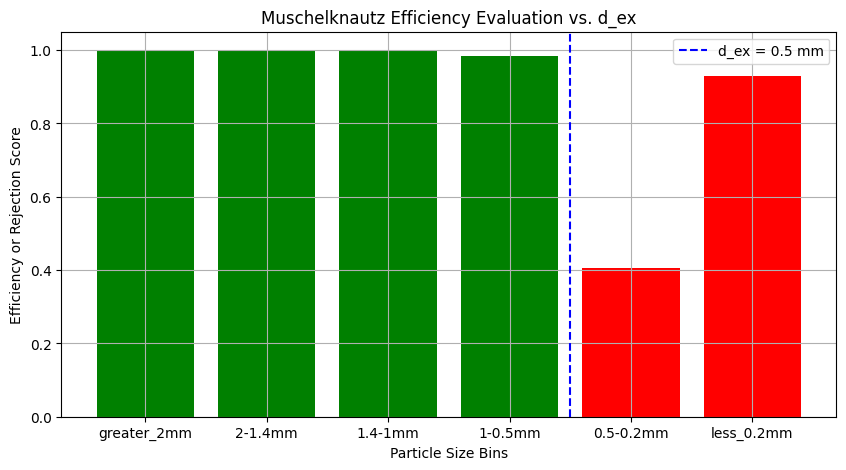

In [ ]:
plt.figure(figsize=(10, 5))
labels = list(cutoff_eval.keys())
values = list(cutoff_eval.values())
colors = ['green' if particle_bins[label] >= d_ex else 'red' for label in labels]

plt.bar(labels, values, color=colors)
plt.axvline(x=3.5, color='blue', linestyle='--', label=f'd_ex = {d_ex} mm')
plt.title('Muschelknautz Efficiency Evaluation vs. d_ex')
plt.xlabel('Particle Size Bins')
plt.ylabel('Efficiency or Rejection Score')
plt.legend()
plt.grid(True)
plt.show()

### 10. Define Optimization Objective Function

This function evaluates a candidate cyclone body diameter (`Dc_candidate`) by calculating the separation efficiencies for all particle size bins using the Muschelknautz model. It then computes a score that reflects the cyclone's selective performance based on the desired cut-off diameter (`d_ex`):

- For particles larger than or equal to `d_ex`, the function subtracts their efficiencies from the score, aiming to **maximize** their collection.
- For smaller particles, it adds their efficiencies to the score, aiming to **minimize** their collection (i.e., maximize rejection).

The overall score thus quantifies how well a given cyclone diameter balances collecting valuable coarse particles while rejecting finer ones, and it is used as the objective for optimization.


In [ ]:
def optimization_objective(Dc_candidate):

    # Calculate efficiencies for all particle sizes
    effs = {
        label: muschelknautz_efficiency(d_p, rho_p, rho_g, mu, Q, Dc_candidate)
        for label, d_p in particle_bins.items()
    }

    # Evaluate against the cutoff
    score = 0
    for label, d_p in particle_bins.items():
        if d_p >= d_ex:
            score -= effs[label]  # we want to maximize collection ⇒ subtract to minimize
        else:
            score += effs[label]  # we want to minimize collection ⇒ add to minimize
    return score

### 11. Run the Optimization

The `minimize_scalar` function from the SciPy library is used here to find the optimal cyclone body diameter (`Dc`) that minimizes the objective score defined earlier.

- It searches for the best `Dc` value within the specified bounds (`0.2 m to 2.0 m`).
- The `method='bounded'` option ensures that the search stays within these limits.
- The optimization attempts to balance maximizing the collection of coarse particles while minimizing the collection of fine particles, as encoded in the objective function.

The result provides the cyclone diameter that achieves the best trade-off according to the model.


In [ ]:
result = minimize_scalar(
    optimization_objective,
    bounds=(0.2, 2.0),  # Search between 0.2 m to 2.0 m
    method='bounded'
)

optimal_Dc = result.x
optimal_score = result.fun
print(f"Optimal Dc: {optimal_Dc:.3f} m\n Objective score: {optimal_score:.4f}")

Optimal Dc: 0.643 m
 Objective score: -3.4708


### 12. Compare Efficiency at Optimal Dc

This bar plot displays the collection efficiencies of the cyclone at the optimized body diameter (`Dc`).

- **Green bars** correspond to particle sizes **equal to or larger than** the cut-off diameter (`d_ex`), indicating how effectively the cyclone collects these coarser particles.
- **Red bars** correspond to particle sizes **smaller than** the cut-off diameter, showing the rejection score (i.e., the cyclone's ability to avoid collecting finer particles).
- The **blue dashed vertical line** marks the cut-off diameter (`d_ex`), visually separating the collected from the rejected particle size ranges.

Overall, this plot demonstrates the cyclone’s improved selective separation performance after optimization of the cyclone diameter.


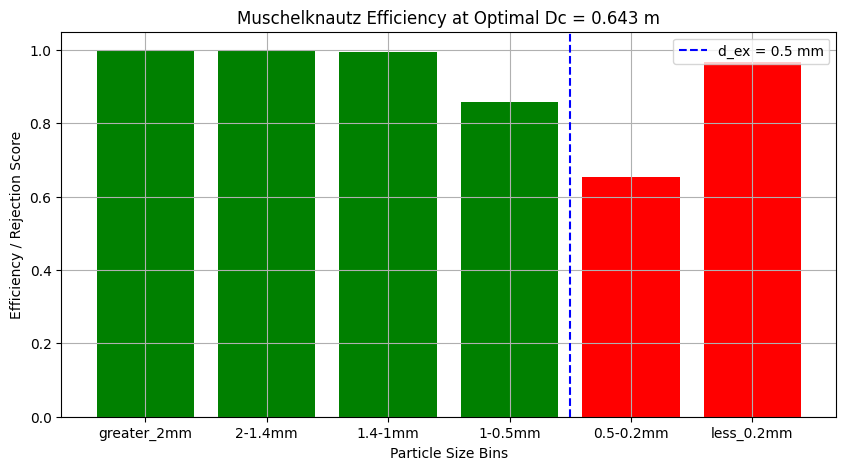

In [ ]:
# Recalculate efficiencies at optimal Dc
optimal_efficiencies = {
    label: muschelknautz_efficiency(d_p, rho_p, rho_g, mu, Q, optimal_Dc)
    for label, d_p in particle_bins.items()
}

# Evaluate cutoff again
optimal_cutoff_eval = evaluate_efficiency_against_cutoff(optimal_efficiencies, d_ex)

# Plot
plt.figure(figsize=(10, 5))
labels = list(optimal_cutoff_eval.keys())
values = list(optimal_cutoff_eval.values())
colors = ['green' if particle_bins[label] >= d_ex else 'red' for label in labels]

plt.bar(labels, values, color=colors)
plt.title(f'Muschelknautz Efficiency at Optimal Dc = {optimal_Dc:.3f} m')
plt.xlabel('Particle Size Bins')
plt.ylabel('Efficiency / Rejection Score')
plt.axvline(x=3.5, color='blue', linestyle='--', label=f'd_ex = {d_ex} mm')
plt.legend()
plt.grid(True)
plt.show()

### 13. Plot Collection Efficiencies at Optimal Dc

This plot visualizes the collection efficiencies for different particle size bins at the optimized cyclone diameter (`Dc`).

- The **green bars** represent particles with sizes **greater than or equal to** the cut-off diameter (`d_ex`), showing the cyclone’s effectiveness in collecting coarser particles.
- The **red bars** represent particles **smaller than** the cut-off diameter, indicating the cyclone’s ability to reject finer particles.
- The **gray dashed line** at 90% efficiency serves as a benchmark for high collection efficiency.
- The **blue dashed line** at 50% efficiency marks the typical cut-off efficiency level used in cyclone design.
- The **orange vertical dashed line** marks the cut-off particle size (`d_ex`) for visual reference.

This plot helps assess how well the cyclone performs in selectively collecting particles at different sizes after diameter optimization.

The table followed, provides the collection efficiency for different particle size bins for optimal diameter and cutoff particle size.


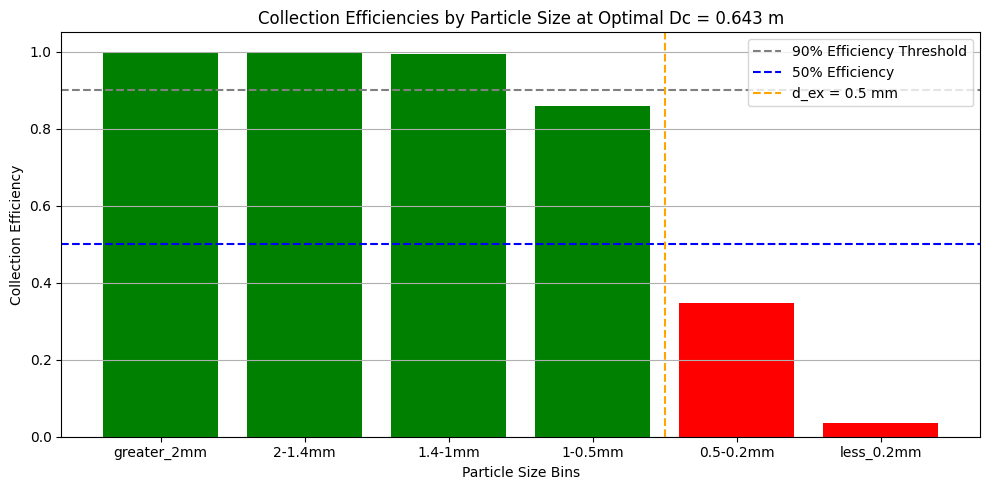

In [ ]:
# Plotting collection efficiencies at optimal Dc
plt.figure(figsize=(10, 5))

particle_labels = list(optimal_efficiencies.keys())
eff_values = list(optimal_efficiencies.values())
particle_sizes = [particle_bins[label]*1000 for label in particle_labels]  # Convert to micrometers for clarity

# Color code: green for particles >= d_ex, red for < d_ex
bar_colors = ['green' if particle_bins[label] >= d_ex else 'red' for label in particle_labels]

# Bar plot
plt.bar(particle_labels, eff_values, color=bar_colors)
plt.axhline(y=0.9, color='gray', linestyle='--', label='90% Efficiency Threshold')
plt.axhline(y=0.5, color='blue', linestyle='--', label='50% Efficiency')
plt.axvline(x=3.5, color='orange', linestyle='--', label=f'd_ex = {d_ex} mm')
plt.title(f'Collection Efficiencies by Particle Size at Optimal Dc = {optimal_Dc:.3f} m')
plt.xlabel('Particle Size Bins')
plt.ylabel('Collection Efficiency')
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
table = list(zip(particle_labels, eff_values))
print(tabulate(table, headers=["Particle Size (mm)", "Efficiency (%)"], tablefmt="grid"))

+----------------------+------------------+
| Particle Size (mm)   |   Efficiency (%) |
+======================+==================+
| greater_2mm          |         1        |
+----------------------+------------------+
| 2-1.4mm              |         0.999956 |
+----------------------+------------------+
| 1.4-1mm              |         0.993241 |
+----------------------+------------------+
| 1-0.5mm              |         0.857994 |
+----------------------+------------------+
| 0.5-0.2mm            |         0.346281 |
+----------------------+------------------+
| less_0.2mm           |         0.034105 |
+----------------------+------------------+


### 14. Optimize Air Flow Rate for Improved Separation

In this section, we aim to optimize the **air flow rate (Q)** for a fixed cyclone diameter (`Dc = 0.643 m`) to achieve the best separation performance based on the desired cut-off particle size (`d_ex = 0.5 mm`).

#### Optimization Objective:
- **Maximize** collection efficiency for **coarser particles** (≥ `d_ex`) — these are valuable for export.
- **Minimize** collection of **finer particles** (< `d_ex`) — these can reduce product quality.

The objective function penalizes or rewards efficiencies depending on whether the particle size is above or below the cut-off, helping to steer the optimizer toward a desirable flow rate.

#### Result:
The `minimize_scalar` function from SciPy is used to find the optimal flow rate within the practical range of **0.1 to 2.0 m³/s**. The result provides:
- The **optimal air flow rate (`Q`)** that best balances the selective collection.
- The **objective score**, indicating how well the cyclone performs at that air flow rate.

Finally, the collection efficiencies at the optimal flow rate are recalculated for all particle size bins and presented in a tabulated form.


In [ ]:
# Set constants
fixed_Dc = optimal_Dc  # m (fixed optimal diameter from earlier)
fixed_cutoff = d_ex  # mm (desired cutoff)

def airflow_optimization_objective(Q_candidate):
    """Objective: maximize separation efficiency above d_ex and minimize below d_ex."""
    score = 0
    for label, d_p in particle_bins.items():
        eff = muschelknautz_efficiency(d_p, rho_p, rho_g, mu, Q_candidate, fixed_Dc)
        if d_p >= fixed_cutoff:
            score -= eff  # maximize efficiency ⇒ subtract to minimize objective
        else:
            score += eff  # minimize efficiency ⇒ add to minimize objective
    return score

# Optimize Q in a reasonable range (e.g., 0.1 to 2.0 m³/s)
airflow_result = minimize_scalar(
    airflow_optimization_objective,
    bounds=(0.1, 2.0),
    method='bounded'
)

optimal_Q = airflow_result.x
optimal_airflow_score = airflow_result.fun
print(f"\nOptimal Air Flow Rate (Q): {optimal_Q:.3f} m³/s")
print(f"Objective score at optimal Q: {optimal_airflow_score:.4f}")

# Recalculate efficiencies with optimal Q
optimal_Q_efficiencies = {
    label: muschelknautz_efficiency(d_p, rho_p, rho_g, mu, optimal_Q, fixed_Dc)
    for label, d_p in particle_bins.items()
}

# Print in table form
particle_labels = list(optimal_Q_efficiencies.keys())
eff_values = list(optimal_Q_efficiencies.values())
table = list(zip(particle_labels, eff_values))
print(tabulate(table, headers=["Particle Size (mm)", "Efficiency (%)"], tablefmt="grid"))



Optimal Air Flow Rate (Q): 0.500 m³/s
Objective score at optimal Q: -3.4708
+----------------------+------------------+
| Particle Size (mm)   |   Efficiency (%) |
+======================+==================+
| greater_2mm          |        1         |
+----------------------+------------------+
| 2-1.4mm              |        0.999956  |
+----------------------+------------------+
| 1.4-1mm              |        0.993241  |
+----------------------+------------------+
| 1-0.5mm              |        0.857994  |
+----------------------+------------------+
| 0.5-0.2mm            |        0.346281  |
+----------------------+------------------+
| less_0.2mm           |        0.0341051 |
+----------------------+------------------+


### 15. Visualizing Efficiency Trends Across Air Flow Rates

This section investigates how the collection efficiency of different particle size bins varies with changes in the **air flow rate (`Q`)**, while keeping the cyclone diameter fixed at `Dc = 0.643 m`.

#### What the Code Does:
- A range of flow rates from **0.1 to 2.0 m³/s** is defined using `np.linspace`.
- For each flow rate, the **Muschelknautz efficiency** is computed for every particle size bin.
- The results are stored and then plotted as line graphs to visualize the **efficiency trends** for each bin over the range of `Q`.

#### Plot Explanation:
- Each line represents the variation in collection efficiency for a specific particle size bin.
- The **black dashed line** marks the **optimal air flow rate (`Q`)** obtained from the previous optimization step.
- The plot helps identify how sensitive different particle sizes are to changes in flow rate and supports decisions about operating conditions that maximize selective collection.

This visualization is crucial for understanding the trade-offs in cyclone performance as the flow rate changes.


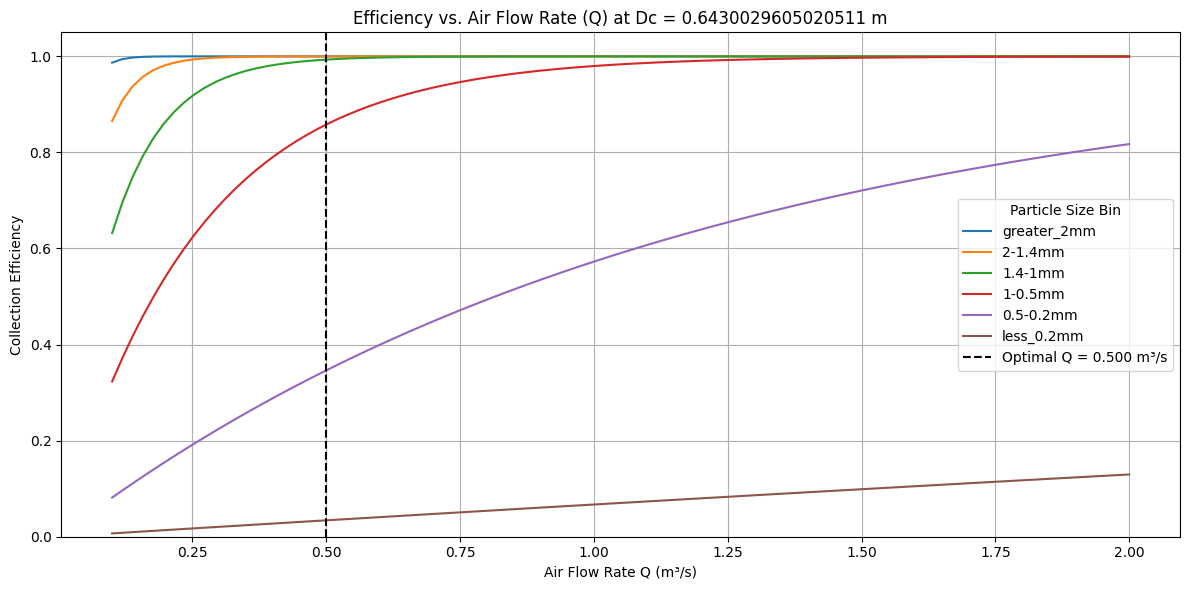

In [ ]:
# Range of air flow rates to evaluate
Q_values = np.linspace(0.1, 2.0, 100)

# Store efficiencies for each particle bin across Q values
eff_curves = {label: [] for label in particle_bins}

for Q_val in Q_values:
    for label, d_p in particle_bins.items():
        eff = muschelknautz_efficiency(d_p, rho_p, rho_g, mu, Q_val, fixed_Dc)
        eff_curves[label].append(eff)

# Plotting
plt.figure(figsize=(12, 6))
for label, effs in eff_curves.items():
    plt.plot(Q_values, effs, label=label)

plt.axvline(optimal_Q, color='black', linestyle='--', label=f'Optimal Q = {optimal_Q:.3f} m³/s')
plt.title(f'Efficiency vs. Air Flow Rate (Q) at Dc = {fixed_Dc} m')
plt.xlabel('Air Flow Rate Q (m³/s)')
plt.ylabel('Collection Efficiency')
plt.grid(True)
plt.legend(title='Particle Size Bin')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


### 16. Total Collection Efficiency for the Datasets

In this section, we calculate the **total collection efficiency** for each sample in two datasets:

- **Dryer Material**
- **Normal Material**

#### How the Efficiency is Computed:
- The `calculate_total_efficiency()` function computes a **weighted sum of efficiencies** for each particle size bin using:
  - The **Muschelknautz model** to calculate efficiency (`η`) for each bin.
  - The **mass fraction** of each size bin from the sample data.
- This gives an overall efficiency score per sample.

#### What the Plot Shows:
- The line graph compares **model-predicted collection efficiencies** across all samples for both datasets using the **optimized cyclone diameter (`Dc`) and air flow rate (`Q`)**.
- It visually highlights differences in separation performance between dryer and normal material, allowing for better process tuning across different production stages.


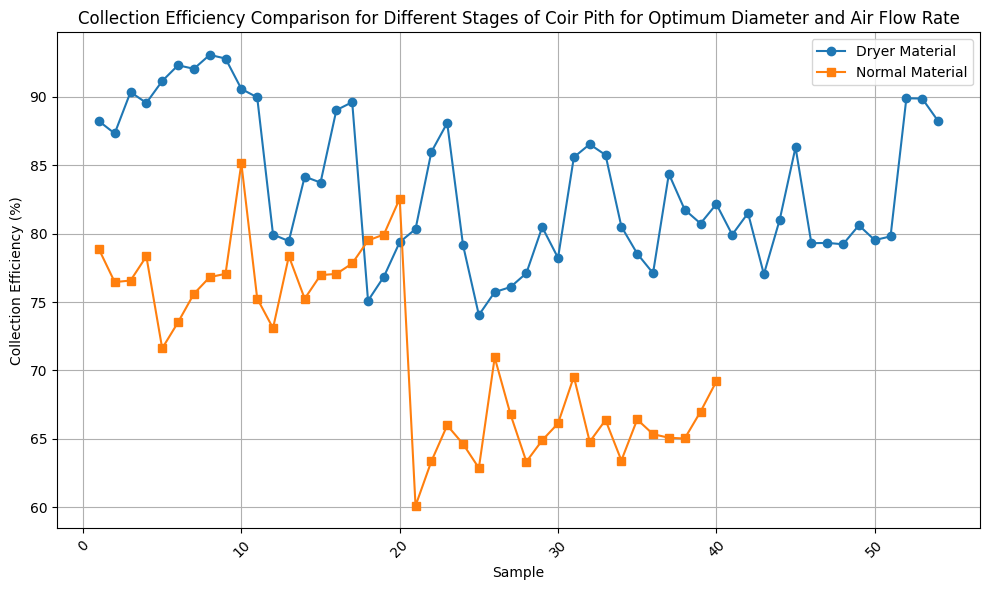

In [ ]:
# --- Efficiency calculator across bins ---
def calculate_total_efficiency(row, rho_p, rho_g, mu, Q, D_c):
    total_efficiency = 0
    for bin_label, mean_d in particle_bins.items():
        eta = muschelknautz_efficiency(mean_d, rho_p, rho_g, mu, Q, D_c)
        mass_fraction = row[bin_label]
        total_efficiency += eta * mass_fraction
    return total_efficiency

# --- Apply to both dataframes ---
data_dryer['Model_Efficiency'] = data_dryer.apply(
    lambda row: calculate_total_efficiency(row, rho_p, rho_g, mu, Q=optimal_Q, D_c=optimal_Dc),
    axis=1
)

data_normal['Model_Efficiency'] = data_normal.apply(
    lambda row: calculate_total_efficiency(row, rho_p, rho_g, mu, Q=optimal_Q, D_c=optimal_Dc),
    axis=1
)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(data_dryer['Sample'], data_dryer['Model_Efficiency'], marker='o', label='Dryer Material')
plt.plot(data_normal['Sample'], data_normal['Model_Efficiency'], marker='s', label='Normal Material')
plt.xlabel('Sample')
plt.ylabel('Collection Efficiency (%)')
plt.title('Collection Efficiency Comparison for Different Stages of Coir Pith for Optimum Diameter and Air Flow Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()